### Jupyterlab magic
Spodnja celica uvozi vse knjižnice (mogoče tudi kakšno preveč) in pripravi nastavitve, ki jih potrebujemo kasneje za računanje in risanje. Poženi pred čemerkoli drugim

In [2]:
import IPython.display as ipd
from math import pi
from numpy import *
from scipy.stats import norm
from scipy.constants import *
from scipy.io import wavfile
import scipy.linalg as s_linalg
from ipywidgets import *
from matplotlib import pyplot as plt
from matplotlib import rcParams as MpRcParams
MpRcParams['mathtext.fontset'] = 'cm'
MpRcParams['mathtext.rm'] = 'serif'
MpRcParams['mathtext.rm'] = 'serif'
%matplotlib inline

# DPCM s predikcijo N-tega reda

## Beri signal

Najprej preberemo signal in ga primerno obdelamo (po potrebi odstranimo en kanal, če je razpon +-1 float (odvisno od wave formata), ga pretvorimo v int16, da je situacija bolj podobna realnemu primeru A/D pretvornika)

In [3]:
samplerate, data = wavfile.read('PrimerGovora15-22k.wav')
data=int16(data*(2**15-1))

<ipython-input-3-73cc2226c5e6>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read('PrimerGovora15-22k.wav')


## Red prediktorja in Avtokorelacija

Izračunamo avtokorelacijo signala, na podlagi katere bomo izračunali koeficiente za predikcijo. V splošnem se to naredi za veliko množico reprezentativnih signalov, tu bomo naredili le za kratek posnetek.

In [6]:
N=5   #red prediktorja
x=hstack((int16(zeros(N)),data))     #vhodenmu signalu dodamo toliko 0, kolikor je red prediktorja, da lahko začne prediktor prav delovati preden se signal zares začne
r=correlate(float64(data),float64(x),mode='valid')    #pri daljših vzorcih ne deluje prav, če je tip int, ker pride prehitro do prekoračenja dosega podatkovnega tipa. Mogoče bi bilo OK, če bi bil tip int64?
c=r/max(r)
c

array([1.        , 0.99305058, 0.97671712, 0.95836651, 0.94050414,
       0.92162021])

## Koeficienti prediktorja

Iz avtokorelacije izračunamo koeficiente $a$ za linearni prediktor

In [7]:
rx=c[1:N+1]
Rx=s_linalg.toeplitz(c[0:N])
a=matmul(linalg.inv(Rx),rx)

display(rx)
display(Rx)
display(a)

array([0.99305058, 0.97671712, 0.95836651, 0.94050414, 0.92162021])

array([[1.        , 0.99305058, 0.97671712, 0.95836651, 0.94050414],
       [0.99305058, 1.        , 0.99305058, 0.97671712, 0.95836651],
       [0.97671712, 0.99305058, 1.        , 0.99305058, 0.97671712],
       [0.95836651, 0.97671712, 0.99305058, 1.        , 0.99305058],
       [0.94050414, 0.95836651, 0.97671712, 0.99305058, 1.        ]])

array([ 2.50790687, -2.96242328,  2.36486701, -1.19028148,  0.27421429])

## Kodiranje PCM signala v DPCM signal in nazaj

23197

3781

2745

158

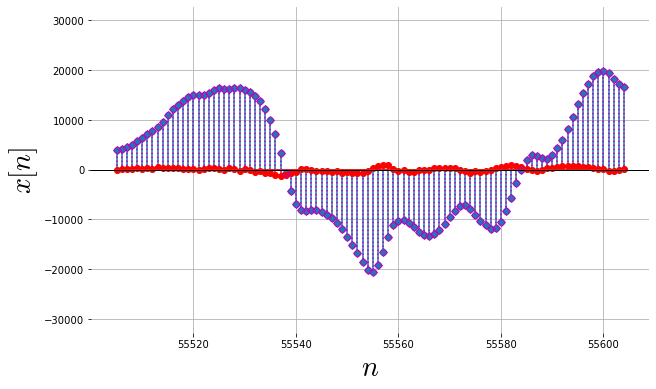

In [8]:
def predictor(x,N):
    xp=0
    n=N-1
    for i in range(0,N):
        xp = xp + a[i]*x[n-i]
    return xp

#kodiranje PCM signala v DPCM
d=zeros(size(x))
for n in range(N,size(x)):
    d[n]=x[n]-predictor(x[n-N:n],N)

#pošiljamo signal razlike d (DPCM) in dekodiramo v y (PCM obliko), ki mora biti enak x
y=zeros(size(x))
for n in range(N,size(x)):
    y[n]=predictor(y[n-N:n],N)+d[n]

    
start=55500+N
Nplt=100
n=arange(start,start+Nplt)
#Risanje
fig, ax= plt.subplots(figsize=(10,6))
ax.stem(n,x[start:start+Nplt])
ax.stem(n,d[start:start+Nplt],'r',markerfmt='ro')
markerline, stemlines, baseline = ax.stem(n,y[start:start+Nplt],'m:',markerfmt='mD')
markerline.set_markerfacecolor('none')
ax.axhline(0, color='black', lw=1)
ax.set_ylim(-2**15,2**15)
plt.ylabel(r'$x[n]$', fontsize=28)
plt.xlabel(r'$n$', fontsize=28)
plt.grid(which="both")
ax.set_frame_on(False)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=16) 

display(round(max(absolute(x))))
display(round(max(absolute(d))))
display(round(std(x)))
display(round(std(d)))
ipd.Audio(y,rate=samplerate)

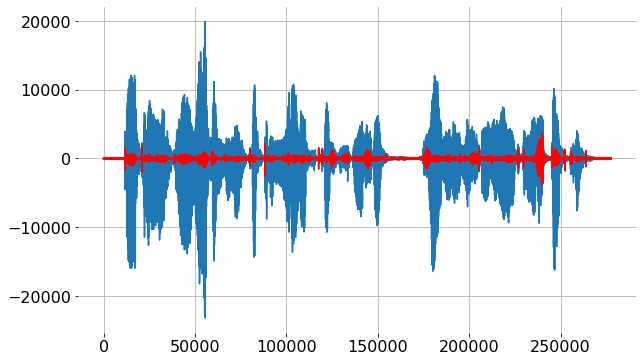

In [9]:
#Risanje
fig, ax= plt.subplots(figsize=(10,6))
ax.plot(x)
ax.plot(d,'r')
ax.set_frame_on(False)
ax.grid(which="both")